# Importing the Libraries

In [2]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers, optimizers
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import layers
from keras.metrics import categorical_crossentropy
from tensorflow.keras import Model, Input
from tensorflow.keras import utils
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

# Loading and Preprocessing the Data


In [3]:
%cp /content/drive/MyDrive/Dataset/ -r /content/

In [4]:
train = tf.keras.utils.image_dataset_from_directory(
    '/content/Dataset/Train',
    labels='inferred' ,
    label_mode = 'categorical',
    color_mode="rgb",
    image_size=(64, 64),
    shuffle=True,
    batch_size=128,
    seed= 10,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

val = tf.keras.utils.image_dataset_from_directory(
    '/content/Dataset/Val',
    labels='inferred' ,
    label_mode = 'categorical',
    color_mode="rgb",
    image_size=(64, 64),
    shuffle=False,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

test = tf.keras.utils.image_dataset_from_directory(
    '/content/Dataset/Test',
    labels='inferred' ,
    label_mode = 'categorical',
    color_mode="rgb",
    image_size=(64, 64),
    shuffle=False,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 5908 files belonging to 4 classes.
Found 855 files belonging to 4 classes.
Found 825 files belonging to 4 classes.


In [5]:
aug_2 = layers.Rescaling(1./255)

train = train.map(lambda x, y: (aug_2(x), y))
val = val.map(lambda x, y: (aug_2(x), y)) 
test = test.map(lambda x, y: (aug_2(x), y)) 

In [6]:
y_test = np.concatenate([y for x, y in val], axis=0)
x_test = np.concatenate([x for x, y in val], axis=0)

# DenseNet

In [7]:
Network = tf.keras.applications.DenseNet121(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(64,64,3),
    pooling='avg',
)
Network.summary()

29084464/29084464 [==============================] - 0s 0us/step
Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)   0           ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 32, 32, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1/conv[0][0]']             
                       

In [8]:
for layer in Network.layers[:-12]: 
  layer.trainable = False
last_layer = Network.get_layer('avg_pool')
last_output = last_layer.output
x = tf.keras.layers.Dense(4, activation='softmax')(last_output)

In [9]:
model = Model(inputs=Network.input, outputs=x) 
model.compile(keras.optimizers.Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
history = model.fit(train, validation_data=val, epochs=20, verbose=1)

Epoch 1/20
47/47 [==============================] - 20s 98ms/step - loss: 2.2420 - accuracy: 0.1652 - val_loss: 1.9999 - val_accuracy: 0.1918
Epoch 2/20
47/47 [==============================] - 2s 44ms/step - loss: 1.8874 - accuracy: 0.2464 - val_loss: 1.7499 - val_accuracy: 0.2561
Epoch 3/20
47/47 [==============================] - 2s 43ms/step - loss: 1.6003 - accuracy: 0.3309 - val_loss: 1.5326 - val_accuracy: 0.3228
Epoch 4/20
47/47 [==============================] - 2s 44ms/step - loss: 1.3773 - accuracy: 0.4130 - val_loss: 1.3464 - val_accuracy: 0.4070
Epoch 5/20
47/47 [==============================] - 2s 44ms/step - loss: 1.2069 - accuracy: 0.4931 - val_loss: 1.1865 - val_accuracy: 0.4901
Epoch 6/20
47/47 [==============================] - 2s 43ms/step - loss: 1.0644 - accuracy: 0.5680 - val_loss: 1.0571 - val_accuracy: 0.5614
Epoch 7/20
47/47 [==============================] - 2s 43ms/step - loss: 0.9527 - accuracy: 0.6259 - val_loss: 0.9504 - val_accuracy: 0.6152
Epoch 8/20
4

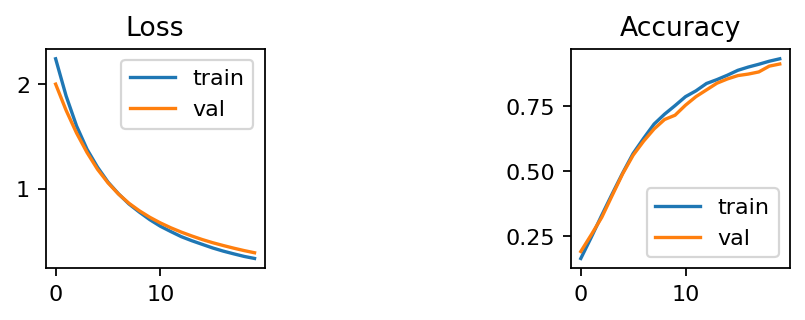

In [11]:
plt.figure( dpi=160)

plt.subplot(231)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()

plt.subplot(233)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.show()

In [12]:
y_hat = model.predict(x_test)

27/27 [==============================] - 2s 15ms/step


In [13]:
y_hat[y_hat>=0.5] = 1
y_hat[y_hat<0.5] = 0


For Test Set
F1 score:  0.8888888888888888
Accuracy:  0.8327485380116959
Precision:  0.9531459170013387
Recall:  0.8327485380116959
Confusion Matrix: 



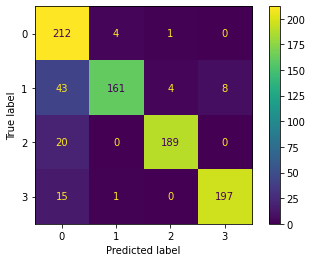

In [14]:
print('\nFor Test Set')
f1 = f1_score(y_test, y_hat, average='micro')
print('F1 score: ' , f1)

accuracy = accuracy_score(y_test, y_hat)
print('Accuracy: ' , accuracy)

precision = precision_score(y_test, y_hat, average='micro')
print('Precision: ' , precision)

recall = recall_score(y_test, y_hat, average='micro')
print('Recall: ' , recall)

matrix = ConfusionMatrixDisplay(confusion_matrix(y_test.argmax(axis=1), y_hat.argmax(axis=1)))
print('Confusion Matrix: \n')
matrix.plot()
plt.show()

# ResNet

In [15]:
Network = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(64,64,3),
    pooling='avg',
)
Network.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1_conv[0][0]']             
                          

In [16]:
for layer in Network.layers[:-11]: 
  layer.trainable = False
last_layer = Network.get_layer('avg_pool')
last_output = last_layer.output
x = tf.keras.layers.Dense(4, activation='softmax')(last_output)

In [17]:
model = Model(inputs=Network.input, outputs=x) 
model.compile(keras.optimizers.Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
history = model.fit(train, validation_data=val, epochs=20, verbose=1)

Epoch 1/20
47/47 [==============================] - 6s 57ms/step - loss: 0.8196 - accuracy: 0.7079 - val_loss: 1.5463 - val_accuracy: 0.2526
Epoch 2/20
47/47 [==============================] - 2s 38ms/step - loss: 0.3966 - accuracy: 0.9025 - val_loss: 1.4844 - val_accuracy: 0.2550
Epoch 3/20
47/47 [==============================] - 2s 37ms/step - loss: 0.2645 - accuracy: 0.9472 - val_loss: 1.7990 - val_accuracy: 0.2538
Epoch 4/20
47/47 [==============================] - 2s 37ms/step - loss: 0.1941 - accuracy: 0.9651 - val_loss: 2.5836 - val_accuracy: 0.3228
Epoch 5/20
47/47 [==============================] - 2s 38ms/step - loss: 0.1480 - accuracy: 0.9744 - val_loss: 3.3210 - val_accuracy: 0.4433
Epoch 6/20
47/47 [==============================] - 2s 37ms/step - loss: 0.1155 - accuracy: 0.9824 - val_loss: 3.9795 - val_accuracy: 0.4655
Epoch 7/20
47/47 [==============================] - 2s 37ms/step - loss: 0.0928 - accuracy: 0.9892 - val_loss: 4.2082 - val_accuracy: 0.4596
Epoch 8/20
47

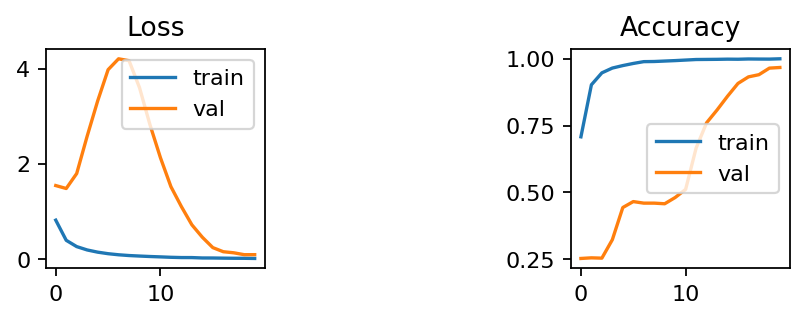

In [19]:
plt.figure( dpi=160)

plt.subplot(231)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()

plt.subplot(233)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.show()

In [20]:
y_hat = model.predict(x_test)

27/27 [==============================] - 1s 8ms/step


In [21]:
y_hat[y_hat>=0.5] = 1
y_hat[y_hat<0.5] = 0


For Test Set
F1 score:  0.9670975323149236
Accuracy:  0.9625730994152046
Precision:  0.9716646989374262
Recall:  0.9625730994152046
Confusion Matrix: 



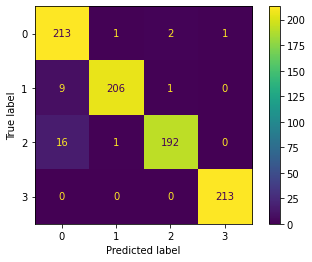

In [22]:
print('\nFor Test Set')
f1 = f1_score(y_test, y_hat, average='micro')
print('F1 score: ' , f1)

accuracy = accuracy_score(y_test, y_hat)
print('Accuracy: ' , accuracy)

precision = precision_score(y_test, y_hat, average='micro')
print('Precision: ' , precision)

recall = recall_score(y_test, y_hat, average='micro')
print('Recall: ' , recall)

matrix = ConfusionMatrixDisplay(confusion_matrix(y_test.argmax(axis=1), y_hat.argmax(axis=1)))
print('Confusion Matrix: \n')
matrix.plot()
plt.show()

# VGG16

In [23]:
Network = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(64,64,3),
    pooling='avg',
)
Network.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                              

In [24]:
for layer in Network.layers[:-9]: 
  layer.trainable = False
last_layer = Network.get_layer('global_average_pooling2d')
last_output = last_layer.output
x = tf.keras.layers.Dense(4, activation='softmax')(last_output)

In [25]:
model = Model(inputs=Network.input, outputs=x) 
model.compile(keras.optimizers.Adam(learning_rate=0.000001), loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
history = model.fit(train, validation_data=val, epochs=20, verbose=1)

Epoch 1/20
47/47 [==============================] - 3s 38ms/step - loss: 1.5682 - accuracy: 0.2751 - val_loss: 1.3720 - val_accuracy: 0.3298
Epoch 2/20
47/47 [==============================] - 2s 35ms/step - loss: 1.2235 - accuracy: 0.5741 - val_loss: 1.0537 - val_accuracy: 0.8363
Epoch 3/20
47/47 [==============================] - 2s 35ms/step - loss: 0.9203 - accuracy: 0.8468 - val_loss: 0.7282 - val_accuracy: 0.9111
Epoch 4/20
47/47 [==============================] - 2s 35ms/step - loss: 0.5894 - accuracy: 0.9262 - val_loss: 0.4227 - val_accuracy: 0.9520
Epoch 5/20
47/47 [==============================] - 2s 35ms/step - loss: 0.3231 - accuracy: 0.9724 - val_loss: 0.2261 - val_accuracy: 0.9789
Epoch 6/20
47/47 [==============================] - 2s 35ms/step - loss: 0.1763 - accuracy: 0.9836 - val_loss: 0.1290 - val_accuracy: 0.9883
Epoch 7/20
47/47 [==============================] - 2s 35ms/step - loss: 0.1066 - accuracy: 0.9900 - val_loss: 0.0823 - val_accuracy: 0.9883
Epoch 8/20
47

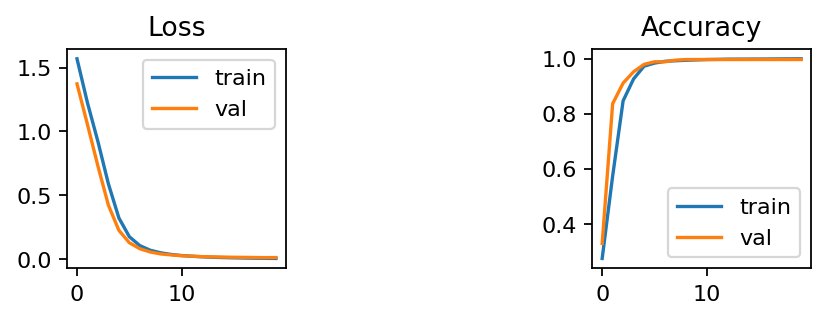

In [27]:
plt.figure( dpi=160)

plt.subplot(231)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()

plt.subplot(233)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.show()

In [28]:
y_hat = model.predict(x_test)

27/27 [==============================] - 0s 4ms/step


In [29]:
y_hat[y_hat>=0.5] = 1
y_hat[y_hat<0.5] = 0


For Test Set
F1 score:  0.9964912280701754
Accuracy:  0.9964912280701754
Precision:  0.9964912280701754
Recall:  0.9964912280701754
Confusion Matrix: 



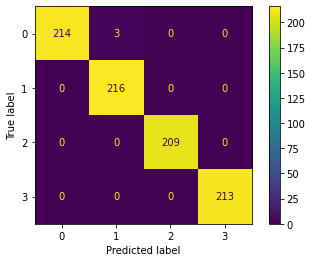

In [30]:
print('\nFor Test Set')
f1 = f1_score(y_test, y_hat, average='micro')
print('F1 score: ' , f1)

accuracy = accuracy_score(y_test, y_hat)
print('Accuracy: ' , accuracy)

precision = precision_score(y_test, y_hat, average='micro')
print('Precision: ' , precision)

recall = recall_score(y_test, y_hat, average='micro')
print('Recall: ' , recall)

matrix = ConfusionMatrixDisplay(confusion_matrix(y_test.argmax(axis=1), y_hat.argmax(axis=1)))
print('Confusion Matrix: \n')
matrix.plot()
plt.show()